# 安裝套件和匯入庫


In [ ]:
# 安裝必要的套件
!pip install -U langchain-community
!pip install google-search-results
!pip install playwright nest_asyncio
!playwright install
# 匯入必要的庫
import asyncio
import csv
import os
import re

import nest_asyncio
import pandas as pd
import requests
from IPython.display import display  # 如果需要使用 display，則保留
from langchain.utilities import SerpAPIWrapper
from playwright.async_api import async_playwright
from tqdm.asyncio import tqdm  # 如果未使用 tqdm，則移除


# 應用 nest_asyncio
nest_asyncio.apply()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=5874c1664e68d9a2170b57f676059bd74ac60c18bcf879bd0c1c8b3c9d716083
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 18.7 MB/s eta 0:00:00
167.7 MiB [] 0% 0.0s167.7 MiB [] 0% 18.6s167.7 MiB [] 0% 8.2s167.7 MiB [] 1% 4.2s167.7 MiB [] 2% 3.3s167.7 MiB [] 2% 2.7s167.7 MiB [] 4% 2.4s167.7 MiB [] 4% 2.2s167.7 MiB [] 5% 2.3s167.7 MiB [] 6% 2.4s167.7 MiB [] 6% 2.3s167.7 MiB [] 7% 2.2s167.7 MiB [] 8% 2.2s167.7 MiB [] 9% 2.2s167.7 MiB [] 10% 2.1s167.7 MiB [] 10% 

In [ ]:
# 設定 SerpAPI 與 HTTP headers（填入你的 Cookie）
os.environ["SERPAPI_API_KEY"] = ""
search = SerpAPIWrapper(params={"hl": "zh-tw", "gl": "tw"})

headers = {
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0",
    "Cookie": "",  # 要帶你的完整 cookie
    "Origin": "https://www.strava.com",
    "Referer": "https://www.strava.com/",
}

COOKIES = [
]

# 定義工具函數

In [ ]:
def calculate_difficulty(distance, avg_grade, elev_high, elev_low):
    return (distance / 1000) * (avg_grade)**2*200 + ((elev_high - elev_low) / 10)

def get_segment_id_from_name(name: str):
    print(f"🔍 正在搜尋：「{name} segment site:veloviewer.com OR site:strava.com」")
    results = search.results(f"{name} segment site:veloviewer.com OR site:strava.com")
    for result in results.get("organic_results", []):
        link = result.get("link", "")
        match = re.search(r"https?://(?:www\.)?(?:veloviewer|strava)\.com/segments/(\d+)", link)
        if match:
            segment_id = int(match.group(1))
            print(f"✔️ 找到 Segment ID：{segment_id}（來自 {link}）")
            return segment_id
    print("❌ 無法從搜尋結果中擷取 Segment ID。")
    print("📄 取得的連結列表：")
    for result in results.get("organic_results", []):
        print(result.get("link", ""))
    raise ValueError("請確認關鍵字是否正確，或 Segment 是否存在於 strava.com / veloviewer.com")

def query_segment(segmentID):
    url = "https://graphql.strava.com/"
    payload = {
        "query": """
        query Segments($segmentIds: [Identifier!]!) {
          segments(segmentIds: $segmentIds) {
            metadata { name }
            measurements { distance avgGrade elevHigh elevLow }
          }
        }
        """,
        "variables": { "segmentIds": [segmentID] },
        "operationName": "Segments"
    }
    response = requests.post(url, json=payload, headers=headers)
    data = response.json()
    segments = data.get("data", {}).get("segments", [])
    if not segments:
        raise ValueError(f"❌ Strava 查無 Segment ID：{segmentID}，可能為私人段或無法公開查詢。")
    seg = segments[0]
    m = seg["measurements"]
    difficulty = calculate_difficulty(m["distance"], m["avgGrade"], m["elevHigh"], m["elevLow"])
    return {
        "Name": seg["metadata"]["name"],
        "Distance (m)": f"{m['distance']:.1f}",
        "Avg Grade (%)": f"{m['avgGrade']:.8f}",
        "Elev High (m)": f"{m['elevHigh']:.1f}",
        "Elev Low (m)": f"{m['elevLow']:.1f}",
        "difficult": f"{difficulty:.1f}"
    }



# Strava 路段排行榜

In [ ]:
import re
import random
import asyncio
import uuid
import time
import hashlib
from urllib.parse import urljoin
from playwright.async_api import Page

def parse_weight_range(text):
    text = text.strip()
    if match := re.match(r"(\d+)\s*kg\s+and\s+under", text, re.IGNORECASE):
        return (int(match.group(1)) - 10, int(match.group(1)))
    if match := re.match(r"(\d+)\s*kg\s+and\s+over", text, re.IGNORECASE):
        return (int(match.group(1)), int(match.group(1)) + 10)
    if match := re.match(r"(\d+)\s*to\s*(\d+)\s*kg", text, re.IGNORECASE):
        return (int(match.group(1)), int(match.group(2)))
    return None
async def extract_leaderboard_data(page: Page, filter_data: dict):
    rows = await page.locator("table.table-leaderboard tbody tr, table.leaderboard tbody tr").all()
    results = []
    min_w, max_w = filter_data["range"]
    median_weight = (min_w + (max_w if max_w is not None else min_w + 10)) / 2

    for row in rows:
        try:
            rank_cell = row.locator("td.text-center").first
            rank = await rank_cell.inner_text()
            if not rank.strip().isdigit():
                avatar = rank_cell.locator("div.avatar-athlete")
                rank = await avatar.get_attribute("title") or ""

            name_el = row.locator("td.athlete a").first
            name = await name_el.inner_text() if name_el else ""

            date_el = row.locator("td.track-click a").nth(1)
            date = await date_el.inner_text() if date_el else ""
            activity_href = await date_el.get_attribute("href") if date_el else ""
            activity_url = urljoin("https://www.strava.com", activity_href) if activity_href else ""

            # 獲取所有欄位並識別時間欄位
            cells = await row.locator("td").all()
            cell_texts = [await cell.inner_text() for cell in cells]

            # 標準欄位位置
            speed = cell_texts[3].strip() if len(cell_texts) > 3 else ""
            hr = cell_texts[4].strip() if len(cell_texts) > 4 else ""
            power = cell_texts[5].strip() if len(cell_texts) > 5 else ""

            # 智能識別時間欄位 - 尋找符合時間格式的欄位(如 mm:ss 或 h:mm:ss)
            time_str = ""
            for text in cell_texts[6:]:  # 從第6個欄位開始檢查
                text = text.strip()
                if re.match(r'^(\d{1,2}:)?\d{1,2}:\d{2}$', text):  # 匹配時間格式
                    time_str = text
                    break
                elif "VAM" in text:  # 跳過VAM欄位
                    continue

            w_per_kg = None
            if power and power != "-" and (m := re.search(r'\d+', power)):
                try:
                    power_value = float(m.group(0))
                    w_per_kg = round(power_value / median_weight, 2)
                except:
                    pass

            results.append({
                "rank": str(rank).strip(),
                "name": name.strip(),
                "weight_group": filter_data["text"],
                "estimated_weight_kg": median_weight,
                "time": time_str,
                "date": date.strip(),
                "activity_url": activity_url,
                "speed": speed,
                "avg_power": power,
                "avg_hr": hr,
                "w_per_kg": w_per_kg
            })

        except Exception as e:
            print(f"\u26a0\ufe0f 解析資料時發生錯誤: {e}")
            continue

    return results

async def get_leaderboard_content_hash(page):
    content = await page.inner_html('#segment-leaderboard')
    return hashlib.md5(content.encode()).hexdigest()

async def wait_for_leaderboard_update(page: Page, old_hash: str, timeout=5000):
    print("⏳ 等待 leaderboard HTML 更新...")
    start = time.time()
    while time.time() - start < timeout / 1000:
        new_hash = await get_leaderboard_content_hash(page)
        if new_hash != old_hash:
            print("✅ Leaderboard 已更新")
            return
        await asyncio.sleep(0.5)
    raise TimeoutError("❌ Leaderboard 資料未更新")

async def click_see_all_weight_filter(page: Page):
    see_all_buttons = page.locator('button.see-all')
    for i in range(await see_all_buttons.count()):
        btn = see_all_buttons.nth(i)
        target = await btn.get_attribute("data-target")
        if target == ".weight-filter" and await btn.is_visible():
            print("🔘 點擊 'See All'（weight-filter）...")
            await btn.scroll_into_view_if_needed()
            await btn.click()
            await asyncio.sleep(1)
            return


async def scrape_weight_filtered_leaderboards(context, segment_id: str):
    url = f"https://www.strava.com/segments/{segment_id}"
    page = await context.new_page()
    weight_data = []
    unique_entries = set()
    success_count = 0

    try:
        await asyncio.sleep(random.uniform(1, 3))
        await page.goto(url, wait_until="networkidle")
        print("⏳ 尋找體重分級過濾器...")

        await click_see_all_weight_filter(page)

        links = page.locator('ul.filters li ul li a[data-filter="weight_class"]')
        await links.first.wait_for(state="attached", timeout=15000)

        weight_filter_data = []
        for i in range(await links.count()):
            try:
                text = await links.nth(i).inner_text()
                weight_range = parse_weight_range(text)
                if weight_range:
                    weight_filter_data.append({
                        "text": text,
                        "range": weight_range,
                        "index": i
                    })
            except Exception as e:
                print(f"⚠️ 忽略第 {i} 項（讀取錯誤: {e}）")

        print(f"✅ 總共找到 {len(weight_filter_data)} 組體重分級")

        for item in weight_filter_data:
            print(f"\n▶️ 篩選: {item['text']} ({item['range']}kg)")
            try:
                await click_see_all_weight_filter(page)

                filter_links = page.locator('ul.filters li ul li a[data-filter="weight_class"]')
                link = filter_links.nth(item["index"])

                print(f"🔍 嘗試 scrollIntoView: {item['text']}")
                try:
                    await page.evaluate('(el) => el.scrollIntoView({behavior: "smooth", block: "center"})', await link.element_handle())
                except Exception as eval_err:
                    print(f"⚠️ JS scrollIntoView 失敗: {str(eval_err)}")

                await link.wait_for(state="visible", timeout=5000)
                old_hash = await get_leaderboard_content_hash(page)
                print("🖱️ 點擊選項中...")
                await link.click()
                await wait_for_leaderboard_update(page, old_hash)
                await asyncio.sleep(2)
                print("📥 從多頁 leaderboard 擷取資料...")
                current_data = await load_all_leaderboard_pages(
                    page,
                    {
                        "text": item["text"],
                        "range": item["range"]
                    },
                    max_pages=8,
                    max_rows=200
                )


                count_added = 0
                for row in current_data:
                    key = f"{row['rank']}-{row['name']}-{row['date']}"
                    if key not in unique_entries:
                        unique_entries.add(key)
                        weight_data.append(row)
                        count_added += 1

                print(f"✅ {item['text']}：成功抓取 {count_added} 筆資料")
                success_count += 1

            except Exception as e:
                screenshot_path = f"/content/{uuid.uuid4()}.png"
                await page.screenshot(path=screenshot_path)
                print(f"❌ 篩選 {item['text']} 發生錯誤: {str(e)}（已截圖: {screenshot_path}）")

        print(f"\n📊 完成：總篩選組數 {len(weight_filter_data)}，成功 {success_count} 組，總共 {len(weight_data)} 筆資料")
        return weight_data

    except Exception as e:
        print(f"⚠️ 主流程錯誤: {e}")
        return []

    finally:
        await page.close()

In [ ]:
async def load_all_leaderboard_pages(page: Page, filter_data: dict, max_pages: int = 8, max_rows: int = 200):
    results = []
    current_page = 1
    unique_entries = set()

    while current_page <= max_pages:
        await page.wait_for_selector("table.table-leaderboard tbody tr, table.leaderboard tbody tr", timeout=10000)
        print(f"📄 第 {current_page} 頁，擷取資料...")

        current_data = await extract_leaderboard_data(page, filter_data)

        count_added = 0
        for row in current_data:
            key = f"{row['rank']}-{row['name']}-{row['date']}"
            if key not in unique_entries:
                unique_entries.add(key)
                results.append(row)
                count_added += 1

        print(f"✅ 第 {current_page} 頁新增 {count_added} 筆（累計 {len(results)} 筆）")

        if len(results) >= max_rows:
            print("🛑 已達最大資料筆數")
            break

        next_btn = page.locator("li.next_page a")
        if await next_btn.is_visible():
            print("➡️ 翻到下一頁")
            await next_btn.scroll_into_view_if_needed()
            await next_btn.click()
            await page.wait_for_timeout(2000)
            current_page += 1
        else:
            print("✅ 無下一頁")
            break

    return results


# 執行主流程

In [ ]:

async def run(segment_id):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        await context.add_cookies([{  # Cookie 格式轉換
            "name": k.strip(), "value": v.strip(), "domain": ".strava.com", "path": "/"
        } for k, v in [c.split("=", 1) for c in headers["Cookie"].split(";")]])

        print("🔍 抓取體重分級排行榜中...")
        data = await scrape_weight_filtered_leaderboards(context, segment_id)

        df = pd.DataFrame(data)
        filename = f"segment_{segment_id}_leaderboard.csv"
        df.to_csv(filename, index=False, encoding="utf-8-sig")
        print(f"\n✅ 完成！已儲存至 {filename}")
        await browser.close()


# 主互動式輸入邏輯

In [ ]:

records = []
while True:
    name = input("請輸入路段名稱（或輸入 0 結束）: ")
    if name == "0":
        df = pd.DataFrame(records)
        df.to_csv("segment_data.csv", index=False, encoding="utf-8-sig")
        print("✅ 已匯出 segment_data.csv")
        break
    try:
        segment_id = get_segment_id_from_name(name)
        info = query_segment(segment_id)
        records.append(info)
        print(f"✅ 成功查詢：{info['Name']}")

        # 額外抓排行榜資料
        asyncio.run(run(segment_id))

    except Exception as e:
        print("❌ 錯誤：", e)


請輸入路段名稱（或輸入 0 結束）: 混元宮到明德宮
🔍 正在搜尋：「混元宮到明德宮 segment site:veloviewer.com OR site:strava.com」
✔️ 找到 Segment ID：3907879（來自 https://veloviewer.com/segments/3907879）
✅ 成功查詢：混元宮到明德宮
🔍 抓取體重分級排行榜中...
⏳ 尋找體重分級過濾器...
🔘 點擊 'See All'（weight-filter）...
✅ 總共找到 6 組體重分級

▶️ 篩選: 54 kg and under ((44, 54)kg)
🔘 點擊 'See All'（weight-filter）...
🔍 嘗試 scrollIntoView: 54 kg and under
❌ 篩選 54 kg and under 發生錯誤: Locator.wait_for: Timeout 5000ms exceeded.
Call log:
  - waiting for locator("ul.filters li ul li a[data-filter=\"weight_class\"]").first to be visible
    15 × locator resolved to hidden <a data-type="html" data-value="0_54" data-remote="true" class=" filter-link" data-filter="weight_class" href="/segments/3907879/leaderboard?filter=weight_class&weight_class=0_54">54 kg and under</a>
（已截圖: /content/4f702da0-7619-4e81-aa24-2edd31152001.png）

▶️ 篩選: 55 to 64 kg ((55, 64)kg)
🔘 點擊 'See All'（weight-filter）...
🔍 嘗試 scrollIntoView: 55 to 64 kg
🖱️ 點擊選項中...
⏳ 等待 leaderboard HTML 更新...
✅ Leaderboard 已更新
📥 從多頁 lead

# 資料分析和視覺化

# 載入資料與清洗

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# 讀取 CSV 檔案
csv_file = "segment_" + str(segment_id) + "_leaderboard.csv"
df = pd.read_csv(csv_file)

# 處理 'time' 欄位成為 time_sec（秒）
if not np.issubdtype(df['time'].dtype, np.number):
    df['time'] = pd.to_datetime(df['time'], format='%M:%S', errors='coerce')
    df = df.dropna(subset=['time'])
    df['time_sec'] = df['time'].dt.minute * 60 + df['time'].dt.second
else:
    df['time_sec'] = df['time']

# 篩選 avg_power 含 "Power Meter" 的資料
df = df[df['avg_power'].astype(str).str.contains("Power Meter", na=False)]

# 解析 avg_power 數值部分（例如從 "354 W Power Meter" 提取 354）
df['avg_power_w'] = df['avg_power'].str.extract(r'(\d+)\s*W').astype(float)

# 計算 w_per_kg = avg_power / estimated_weight_kg
df['w_per_kg'] = df['avg_power_w'] / df['estimated_weight_kg']

# 移除無效資料
df = df.dropna(subset=['w_per_kg', 'time_sec'])

df.head()


,rank,name,weight_group,estimated_weight_kg,time,date,activity_url,speed,avg_power,avg_hr,w_per_kg,time_sec,avg_power_w
0,Centrone ivan,Centrone ivan,55 to 64 kg,59.5,1900-01-01 00:02:30,"Mar 9, 2024",https://www.strava.com/segment_efforts/3201413...,23.3 km/h,449 W Power Meter,160 bpm,7.546218,150,449.0
3,4,Jaka Primožič,55 to 64 kg,59.5,1900-01-01 00:02:47,"Mar 15, 2025",https://www.strava.com/segment_efforts/3335931...,21.0 km/h,389 W Power Meter,174 bpm,6.537815,167,389.0
5,5,Robbie Hucker,55 to 64 kg,59.5,1900-01-01 00:02:49,"Mar 10, 2018",https://www.strava.com/segment_efforts/3593476...,20.7 km/h,356 W Power Meter,175 bpm,5.983193,169,356.0
7,8,Kai Jay,55 to 64 kg,59.5,1900-01-01 00:02:51,"May 14, 2023",https://www.strava.com/segment_efforts/3092663...,20.5 km/h,322 W Power Meter,-,5.411765,171,322.0
8,9,維庸 曾,55 to 64 kg,59.5,1900-01-01 00:02:52,"Jul 31, 2024",https://www.strava.com/segment_efforts/3253519...,20.3 km/h,344 W Power Meter,114 bpm,5.781513,172,344.0


# 📊 3. 移除離群值（IQR 法）

In [ ]:
IQR_multiplier = 2.0  # 改為 2.0 或更高以減少刪除筆數

# w/kg
Q1, Q3 = df['w_per_kg'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df = df[(df['w_per_kg'] >= Q1 - IQR_multiplier * IQR) & (df['w_per_kg'] <= Q3 + IQR_multiplier * IQR)]

# time_sec
Q1_time, Q3_time = df['time_sec'].quantile([0.25, 0.75])
IQR_time = Q3_time - Q1_time
df = df[(df['time_sec'] >= Q1_time - IQR_multiplier * IQR_time) & (df['time_sec'] <= Q3_time + IQR_multiplier * IQR_time)]


df = df.sort_values(by='time_sec')
df.describe()


,estimated_weight_kg,time,w_per_kg,time_sec,avg_power_w,speed_kmh,avg_hr_bpm,efficiency_kmh_per_w,power_per_bpm
count,96.000000,96,96.000000,96.000000,96.000000,96.000000,57.000000,96.000000,57.000000
mean,71.270833,1900-01-01 00:03:10.302083072,4.674010,190.302083,328.739583,18.505208,169.350877,0.057906,1.967877
min,59.500000,1900-01-01 00:02:35,2.374101,155.000000,165.000000,15.100000,114.000000,0.039083,1.078431
25%,59.500000,1900-01-01 00:02:59,4.150838,179.000000,305.750000,17.700000,165.000000,0.050453,1.734463
50%,69.500000,1900-01-01 00:03:10.500000,4.689862,190.500000,329.000000,18.350000,169.000000,0.056251,1.970588
75%,79.500000,1900-01-01 00:03:18,5.190647,198.000000,356.500000,19.600000,177.000000,0.060537,2.181287
max,89.500000,1900-01-01 00:03:51,6.537815,231.000000,461.000000,22.600000,198.000000,0.115152,3.017544
std,10.462443,NaN,0.818863,15.379494,53.129285,1.508179,13.549501,0.011933,0.363000


# 📈 4. W/kg vs 時間（含線性回歸趨勢線）

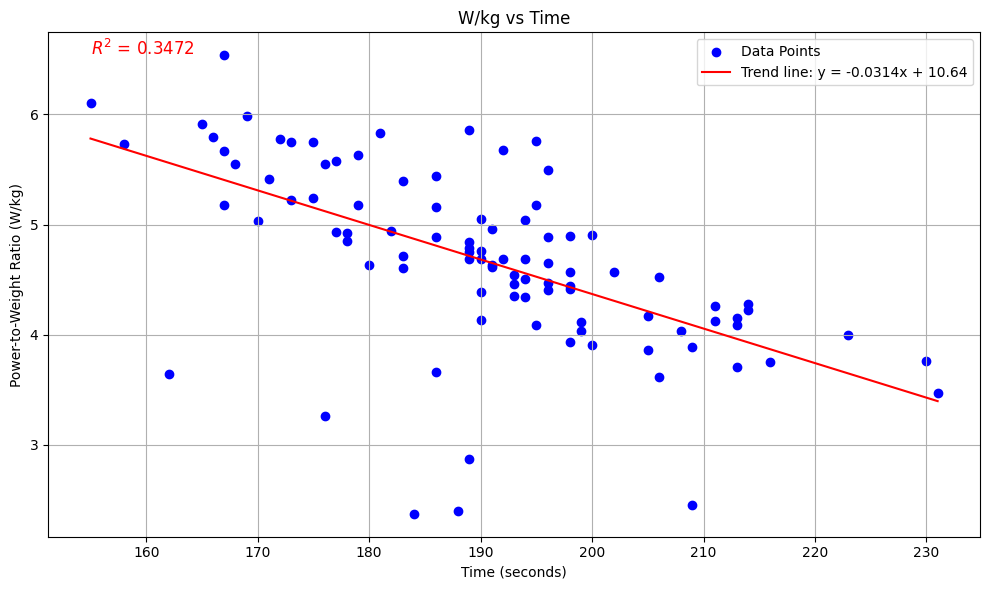

In [ ]:
import matplotlib.pyplot as plt

# 回歸變數
x = df['time_sec'].values
y = df['w_per_kg'].values
a, b = np.polyfit(x, y, 1)
y_pred = a * x + b

# R^2
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# 繪圖
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x, y_pred, color='red', label=f'Trend line: y = {a:.4f}x + {b:.2f}')
plt.text(min(x), max(y), f'$R^2$ = {r_squared:.4f}', fontsize=12, color='red')
plt.title('W/kg vs Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Power-to-Weight Ratio (W/kg)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 📊 5. 體重組別統計摘要（平均值比較）

In [ ]:
group_stats = df.groupby("weight_group")[["time_sec", "avg_power_w", "w_per_kg"]].mean().round(2)
group_stats


,time_sec,avg_power_w,w_per_kg
weight_group,,,
55 to 64 kg,185.61,307.24,5.16
65 to 74 kg,180.88,329.92,4.75
75 to 84 kg,197.15,340.77,4.29
85 to 94 kg,208.00,359.33,4.01


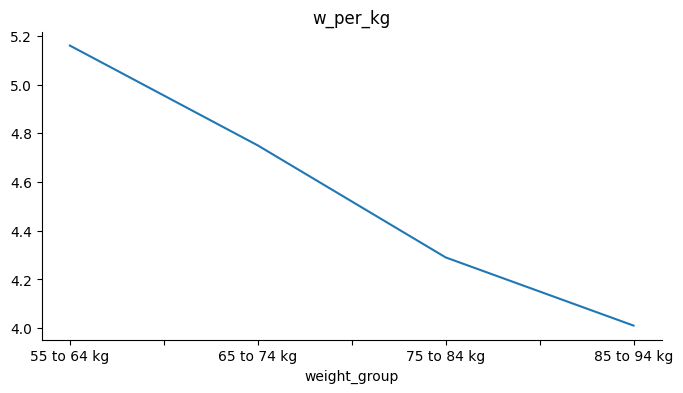

In [ ]:
# @title w_per_kg

from matplotlib import pyplot as plt
group_stats['w_per_kg'].plot(kind='line', figsize=(8, 4), title='w_per_kg')
plt.gca().spines[['top', 'right']].set_visible(False)

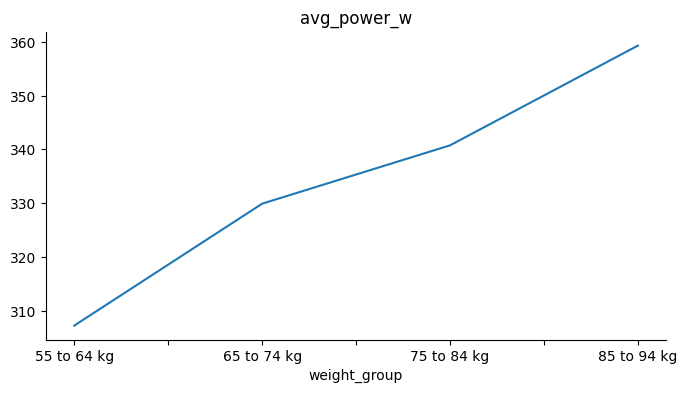

In [ ]:
# @title avg_power_w

from matplotlib import pyplot as plt
group_stats['avg_power_w'].plot(kind='line', figsize=(8, 4), title='avg_power_w')
plt.gca().spines[['top', 'right']].set_visible(False)

# 📉 6. 功率與時間關係圖（Average Power vs Time）

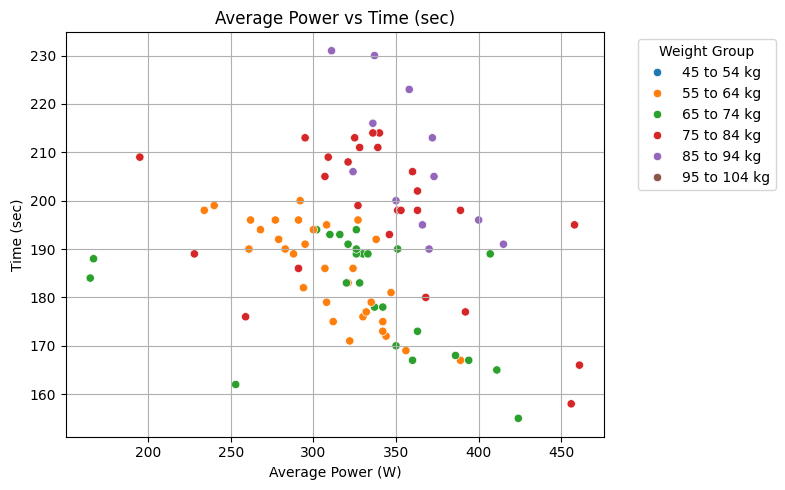

In [ ]:
hue_order = ['45 to 54 kg', '55 to 64 kg', '65 to 74 kg', '75 to 84 kg', '85 to 94 kg', '95 to 104 kg']


plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='avg_power_w', y='time_sec', hue='weight_group', hue_order=hue_order)
plt.title("Average Power vs Time (sec)")
plt.xlabel("Average Power (W)")
plt.ylabel("Time (sec)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Weight Group')
plt.tight_layout()
plt.show()


# 🌀 7. 功率效率（km/h per watt）& 心率效率

In [ ]:
# 若 speed 與 avg_hr 欄位存在可用格式
df['speed_kmh'] = df['speed'].str.replace(" km/h", "", regex=False).astype(float)
df['avg_hr_bpm'] = df['avg_hr'].str.extract(r'(\d+)').astype(float)

# 計算效率
df['efficiency_kmh_per_w'] = df['speed_kmh'] / df['avg_power_w']
df['power_per_bpm'] = df['avg_power_w'] / df['avg_hr_bpm']

# 描述統計
df[["efficiency_kmh_per_w", "power_per_bpm"]].describe()


NameError: name 'df' is not defined

# 訓練AI model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from datetime import datetime

segment_id = 3907879
# 讀取 CSV 檔案
csv_file = "segment_" + str(segment_id) + "_leaderboard.csv"
df = pd.read_csv(csv_file)

# 假設時間欄位是 'time'，格式例如 '9:38'（分:秒）
def time_to_seconds(t):
    if pd.isna(t) or not isinstance(t, str):
        return np.nan
    parts = t.strip().split(':')
    if len(parts) == 3 and parts[2] == '00':  # 處理 MM:SS:00 格式
        try:
            m, s = int(parts[0]), int(parts[1])
            return m * 60 + s
        except ValueError:
            return np.nan
    elif len(parts) == 2:
        try:
            m, s = int(parts[0]), int(parts[1])
            return m * 60 + s
        except ValueError:
            return np.nan
    return np.nan

# 轉換時間欄位
df['time_sec'] = df['time'].apply(time_to_seconds)

# 刪除 time_sec 欄位為 NaN 的列
df = df.dropna(subset=['time_sec']).reset_index(drop=True)


# 補齊缺失值（舉例平均補齊，依需求調整）
df['avg_power_w'] = df['avg_power'].str.extract(r'(\d+)').astype(float)  # 取數字部分轉float
df['avg_power_w'].fillna(df['avg_power_w'].mean(), inplace=True)
df['w_per_kg'].fillna(df['w_per_kg'].mean(), inplace=True)
df['speed'] = df['speed'].str.replace(' km/h', '').astype(float)

# 假設你的 dataframe 是 df，date 欄是類似 "Apr 15, 2020"
# 1. 先轉 datetime
df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y', errors='coerce')

# 2. 定義季節函式
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


# 前面日期與季節欄位處理
df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y', errors='coerce')
df['season'] = df['date'].dt.month.apply(get_season)
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)

segment_info = {
    'segment_distance_m': 4114.6,
    'segment_avg_grade': 6.45,
    'segment_difficulty': 34315
}
for k, v in segment_info.items():
    df[k] = v


# 篩選需要欄位（示例）
features = [
    'estimated_weight_kg', 'avg_power_w', 'w_per_kg',
    'segment_distance_m', 'segment_avg_grade', 'segment_difficulty',
    'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter'
]
print("資料中 features 欄位是否存在：")
print(df[features].isnull().sum())  # 確認缺失值是否還在
print("資料中 time_sec 欄位是否存在：")
print(df['time_sec'].isnull().sum())

X = df[features]
y = df['time_sec']


資料中 features 欄位是否存在：
estimated_weight_kg    0
avg_power_w            0
w_per_kg               0
segment_distance_m     0
segment_avg_grade      0
segment_difficulty     0
season_Fall            0
season_Spring          0
season_Summer          0
season_Winter          0
dtype: int64
資料中 time_sec 欄位是否存在：
0


<ipython-input-53-292091e30cae>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_power_w'].fillna(df['avg_power_w'].mean(), inplace=True)
<ipython-input-53-292091e30cae>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [ ]:


# -------- 2. 切分訓練集與測試集 --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# -------- 3. 線性回歸模型 --------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 評估 Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression Performance:")
print(f"R²: {r2_lr:.3f}, MAE: {mae_lr:.3f} sec, RMSE: {rmse_lr:.3f} sec\n")

# -------- 4. XGBoost 模型 --------
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 評估 XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("XGBoost Performance:")
print(f"R²: {r2_xgb:.3f}, MAE: {mae_xgb:.3f} sec, RMSE: {rmse_xgb:.3f} sec\n")


Linear Regression Performance:
R²: 0.747, MAE: 76.986 sec, RMSE: 134.921 sec

XGBoost Performance:
R²: 0.709, MAE: 71.118 sec, RMSE: 144.787 sec



# 使用model模擬時間

In [ ]:
def simulate_ride(model, weight_kg, avg_power_w, w_per_kg,
                  distance_m, avg_grade, difficulty, season='Spring'):
    input_df = pd.DataFrame([{
        'estimated_weight_kg': weight_kg,
        'avg_power_w': avg_power_w,
        'w_per_kg': w_per_kg,
        'segment_distance_m': distance_m,
        'segment_avg_grade': avg_grade,
        'segment_difficulty': difficulty,
        'season_Fall': 1 if season == 'Fall' else 0,
        'season_Spring': 1 if season == 'Spring' else 0,
        'season_Summer': 1 if season == 'Summer' else 0,
        'season_Winter': 1 if season == 'Winter' else 0,
    }])
    pred_time_sec = model.predict(input_df)[0]
    return round(pred_time_sec, 1)


In [ ]:
simulate_ride(xgb_model,
              weight_kg=60,
              avg_power_w=300,
              w_per_kg=5.0,
              distance_m=3000,
              avg_grade=4.5,
              difficulty=5.2,
              season='Spring')


np.float32(814.1)

# 儲存模型

In [ ]:
import joblib
joblib.dump(xgb_model, 'xgb_model_segment_'+str(segment_id)+'.pkl')


['xgb_model_segment_3907879.pkl']

 # 使用 SHAP 解釋 XGBoost 特徵貢獻

In [ ]:
print(X_train.dtypes)



estimated_weight_kg    float64
avg_power_w            float64
w_per_kg               float64
segment_distance_m     float64
segment_avg_grade      float64
segment_difficulty       int64
season_Fall               bool
season_Spring             bool
season_Summer             bool
season_Winter             bool
dtype: object


In [ ]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)


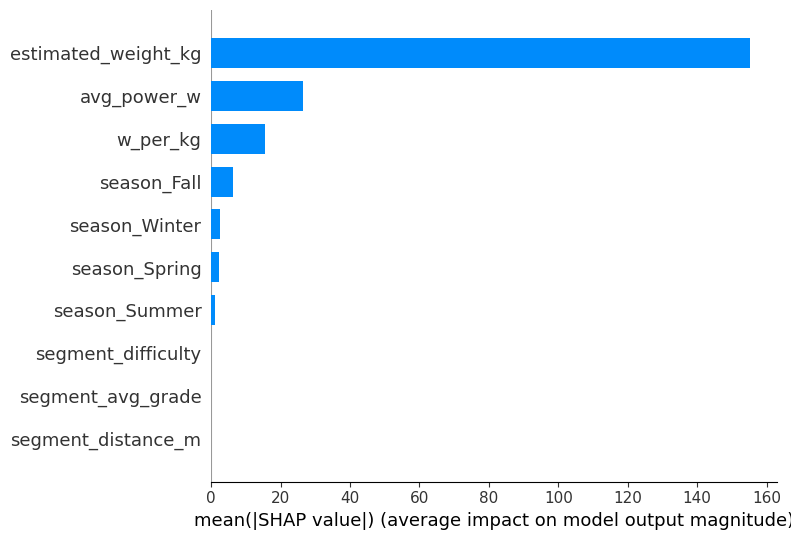

In [ ]:
import shap

# 建立 explainer
explainer = shap.Explainer(xgb_model, X_train)

# 計算 SHAP 值
shap_values = explainer(X_test)

# 視覺化
shap.summary_plot(shap_values, X_test, plot_type="bar")


# 參數調整與交叉驗證

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid = GridSearchCV(XGBRegressor(objective='reg:squarederror'),
                    param_grid,
                    cv=5,
                    scoring='neg_mean_absolute_error',
                    verbose=1)

grid.fit(X_train, y_train)

print("最佳參數：", grid.best_params_)
print("最佳 MAE：", -grid.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
最佳參數： {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
最佳 MAE： 60.64229153508175
